# Stellar-to-halo mass relation

The stellar-to-halo mass relation (SHMR) is one of the fundamental relations when looking at a population of galaxies. It is well known that the evolution and properties of galaxies are strongly correlated to their DM halos. The SHMR is one that is easily available in computer models such as the IllustrisTNG, as the masses of different types of particles are directly part of the simulation.

Here, the SHMR is calculated from the group catalogs of the TNG100-1 run at redshift 0.

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from uncertainties import ufloat
from decimal import *

#constants
h_tng = 0.678 #Planck 2015
h_b = 0.7 #behroozi
h_m = 0.704 #moster
h_z = 0.7
G = 4.3*10**(-6) #  kpc/M_o*(km/s)**2

In [2]:
def double_power_law(b, c, M1, N):
    xmin, xmax = 9, 14
    x=np.logspace(xmin,xmax,200)
    y = 2*N*x*((x/M1)**(-b)+(x/M1)**(c))**(-1)
    return x,y

def behroozi(a, M1, c, d, e):
    def f(x):
        f = -np.log10(10**(a*x)+1)+d*((np.log10(1+np.exp(x)))**c)/(1+np.exp(10**(-x)))
        return f
    xmin, xmax = 9, 14
    X=np.logspace(xmin,xmax,200)
    Y_log = np.log10(e*M1)+f(np.log10(X/M1)) - f(0) #gives log(y)
    return X, 10**(Y_log)

In [3]:
data_centrals = pd.read_pickle("../data/tng-100-1/cutdata/Subhalo_Centrals_minE8_SM.pkl")
sami = pd.read_csv("../data/SAMI/all_data_vrot.csv")
data_centrals["SubhaloHalfmassRadStellar"] = data_centrals["SubhaloHalfmassRadStellar"]/h_tng
data_centrals_log = il.formatplot.log_formater(data_centrals)
sami_log = il.formatplot.log_formater(sami)

It is interesting to separate out the central galaxies and look at their SHMR. Central galaxies are much less affected by their environment as they are the dominant galaxy in their group (if not the only). Thus, central galaxies have properties that are more universal than satellites. Field galaxies have no other galaxies in their group and are therefore even less affected by environmental factors.

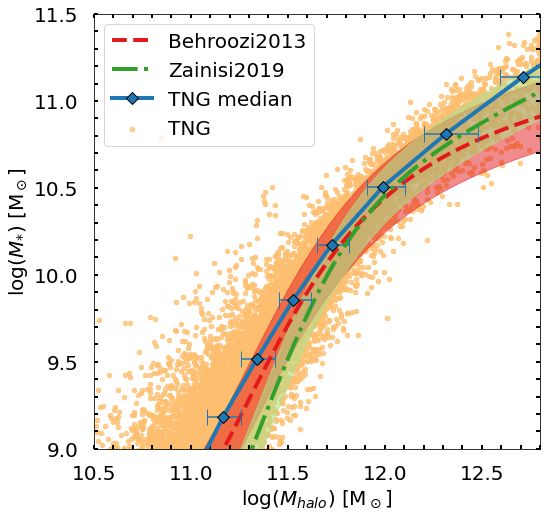

In [4]:
#Create the plot
fig2, ax2 = plt.subplots(figsize = (8,8))
data_centrals_log.plot.scatter(x = "SubhaloMassDM", y = "SubhaloMassStellar", s = 20, color = "#fdbf6f", alpha = 0.8, ax = ax2, label = "TNG")

#Moster 2012
M2012x, M2012y = double_power_law(b = 1.376, c = 0.608,M1 = 10**11.590, N = 0.0351)
#converting to same cosmology
M2012x = M2012x*h_m/h_tng
M2012y = M2012y*h_m**2/h_tng**2
#ax2.plot(np.log10(M2012x),np.log10(M2012y), c="#7570b3", linewidth=4, label= "Moster2012")

#Behroozi 2013
B2013x, B2013y = behroozi(a=-1.412, M1=10**(11.514), c=0.316, d=3.508, e=10**(-1.777))
#converting to same cosmology
B2013x = B2013x*h_b/h_tng
B2013y = B2013y*h_b**2/h_tng**2
#Adding maximum error in log format
B_errors = il.stats.error_estimate_behroozi(a=-1.412, M1=(10**11.514), c=0.316, d=3.508, e=10**(-1.777), delta_a=0.02, delta_M1=0.053, delta_c=0.076, delta_d=0.087, delta_e=0.053, x=B2013x)
#print(B_errors[0])
B_err_lower = np.log10(B2013y) - 0.2
B_err_upper = np.log10(B2013y) + 0.2
ax2.plot(np.log10(B2013x), np.log10(B2013y), "--", c="#e31a1c", linewidth=4, label= "Behroozi2013")
ax2.fill_between(np.log10(B2013x), B_err_lower, B_err_upper, alpha=0.5, color="#e31a1c")

#Zainisi 2019
Z2019x, Z2019y = behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785))
#converting to same cosmology
Z2019x = Z2019x*h_z/h_tng
Z2019y = Z2019y*h_z**2/h_tng**2
#Adding maximum error in log format
#Z_errors = il.stats.error_estimate_behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785), delta_a=0.026, delta_M1=0.008, delta_c=0.1, delta_d=0.052, delta_e=0.01, x=Z2019x)
Z_err_lower = np.log10(Z2019y) - 0.16 #Z_errors
Z_err_upper = np.log10(Z2019y) + 0.16 #Z_errors
ax2.plot(np.log10(Z2019x), np.log10(Z2019y), "-.", c="#33a02c", linewidth=4, label= "Zainisi2019")
ax2.fill_between(np.log10(Z2019x), Z_err_lower, Z_err_upper, alpha=0.6, color="#b2df8a")

#Calculate mean values TNG
mTNG_x, mTNG_y, eTNG_x, eTNG_y = il.stats.median_values_log_y(data_centrals, "tng", "SubhaloMassDM", "SubhaloMassStellar", ymin=8.7, n=11, error_out=True)
eTNG_x, eTNG_y = il.stats.log_errors(eTNG_x, eTNG_y, mTNG_x, mTNG_y)
ax2.errorbar(np.log10(mTNG_x), np.log10(mTNG_y), xerr=eTNG_x, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
ax2.plot(np.log10(mTNG_x), np.log10(mTNG_y), marker='D', linewidth=4, markersize=8, c="#1f78b4", markeredgecolor = "black", label = "TNG median")

il.formatplot.HM_SM(ax=ax2, y0=9, y1=11.5, x0=10.5, x1=12.8)
#plt.savefig("../fig/results_shmr.png", dpi=300, bbox_inches='tight')